# **Laily Khoirunnisa'**

`Garbage Classification`

***Submission akhir Dicoding kelas Pengembangan Machine Learning***

<h3><strong>Import Library </strong></h3>

In [1]:
import numpy as np
import tensorflow as tf

#import keras api needed to implement deep learning techiques
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import os, zipfile
from google.colab import files

#Allow charts and graphics to display right below the page of browser setup
%matplotlib inline

<h3><strong>Mengambil Data dari Kaggle</strong></h3>

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/tmp/"
!chmod 600 /tmp/kaggle.json
#the path where kaggle.json is present in the Google Drive

In [4]:
!kaggle datasets download -d mostafaabla/garbage-classification

 94% 225M/239M [00:03<00:00, 64.5MB/s]
100% 239M/239M [00:03<00:00, 74.8MB/s]


In [5]:
local_zip = 'garbage-classification.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [7]:
data_dir = '/tmp/garbage_classification/'
classes = [name for name in os.listdir(data_dir)]
num_classes = len(classes)
IMG_SIZE = 256
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
batch_size = 16

<h3><strong>Pembagian dan Preprocessing Data</strong></h3>

In [8]:
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2).flow_from_directory(
        directory=data_dir, 
        target_size=(IMG_SIZE,IMG_SIZE), 
        classes=classes, 
        batch_size=batch_size,
        shuffle=True,
        interpolation='nearest',
        subset='training')


# extract images to validation set
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2).flow_from_directory(
      directory=data_dir, 
      target_size=(IMG_SIZE,IMG_SIZE), 
      classes=classes, 
      batch_size=batch_size,
      shuffle=True,
      interpolation='nearest',
      subset='validation')

Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.


<h3><strong>Contoh Gambar Preprocessing Data Training 
</strong></h3>




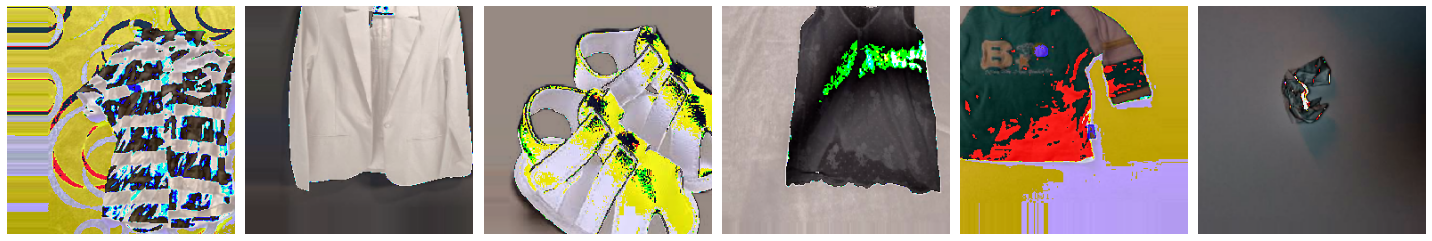

In [10]:
def plotImages(images):
    fig, axes = plt.subplots(1, 6, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

imgs, labels = next(train_batches)
plotImages(imgs)

<h3><strong>Contoh Gambar Preprocessing Data Validasi </strong></h3>

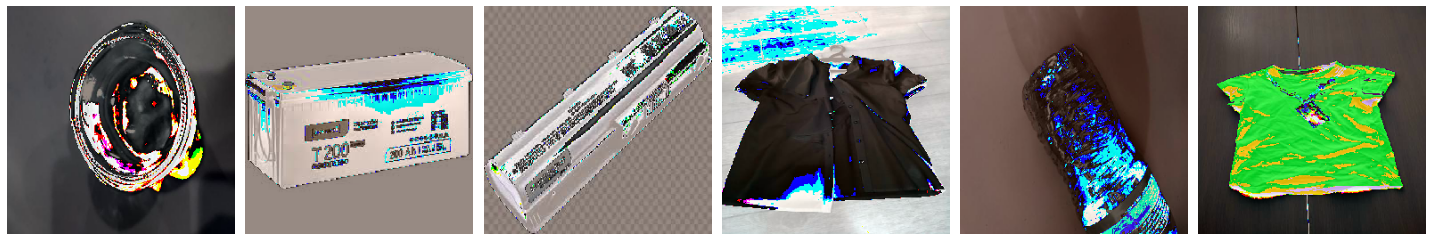

In [11]:
imgs, labels = next(valid_batches)
plotImages(imgs)

<h3><strong>Pembuatan Model </strong></h3>




In [12]:
# import the convolution base of the VGG16 model with pre-trained weights
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, 
                                        include_top=False,
                                        weights='imagenet')

58892288/58889256 [==============================] - 1s 0us/step


In [13]:
model = Sequential()
# Freeze the convolutional base of VGG16 to prevent the pre-trained weights being updated 
# during training inorder to extract features
base_model.trainable=False

# add VGG16 convolution base to initialize sequential model
model.add(base_model)

# add Conv2D, BatchNormalization, MaxPooling2D, Flatten pooling layer
model.add(Conv2D(512, (3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

# add densely-connected NN layer with 512 hidden units
model.add(Dense(units=512, activation='relu'))  # use ReLU activation function
model.add(BatchNormalization())                 # normalize and scale inputs or activations
model.add(Dropout(0.2))                         # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 128 hidden units
model.add(Dense(units=128, activation='relu')) # use ReLU activation function
model.add(BatchNormalization())                # normalize and scale inputs or activations
model.add(Dropout(0.2))                        # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with num_classes hidden units
model.add(Dense(units=num_classes, activation='softmax')) # use Softmax activation function to do final predictions

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 512)         2359808   
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 512)         2048      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

<h3><strong>Mendefinisikan
<code>Callback</code></strong></h3>

In [15]:
#EarlyStopping and ModelCheckpoint

from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 2, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 2, save_best_only = True)

<h3><strong>Training Model dan Pengujian Akurasi Data</strong></h3>

In [16]:
history = model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=1, callbacks=[es,mc])

Epoch 1/30
776/776 [==============================] - 242s 266ms/step - loss: 0.7192 - accuracy: 0.7851 - val_loss: 0.3826 - val_accuracy: 0.8716

Epoch 00001: val_accuracy improved from -inf to 0.87161, saving model to ./model.h5
Epoch 2/30
776/776 [==============================] - 199s 256ms/step - loss: 0.3474 - accuracy: 0.8942 - val_loss: 0.2758 - val_accuracy: 0.9100

Epoch 00002: val_accuracy improved from 0.87161 to 0.91000, saving model to ./model.h5
Epoch 3/30
776/776 [==============================] - 199s 256ms/step - loss: 0.2683 - accuracy: 0.9163 - val_loss: 0.3098 - val_accuracy: 0.9048

Epoch 00003: val_accuracy did not improve from 0.91000
Epoch 4/30
776/776 [==============================] - 197s 254ms/step - loss: 0.2273 - accuracy: 0.9286 - val_loss: 0.2550 - val_accuracy: 0.9177

Epoch 00004: val_accuracy improved from 0.91000 to 0.91774, saving model to ./model.h5
Epoch 5/30
776/776 [==============================] - 197s 253ms/step - loss: 0.1965 - accuracy: 0.

<h3><strong>Plot Grafik Training dan Validation</strong></h3>

Text(0.5, 1.0, 'Training-Validation Loss')

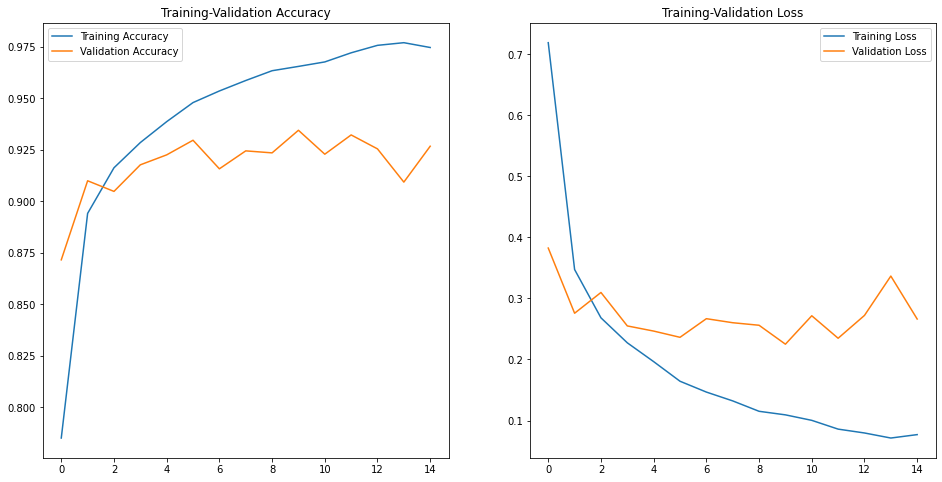

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epoch = range(1, len(loss)+1)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc='upper left')
plt.title('Training-Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.title('Training-Validation Loss')

<h3><strong>Membuat Model Format 
<code>tflite</code></strong></h3>




In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

!ls -la | grep 'model'

INFO:tensorflow:Assets written to: /tmp/tmp7ppadt75/assets
-rw-r--r-- 1 root root 138471728 Jun 27 13:28 model.h5
-rw-r--r-- 1 root root  85366644 Jun 27 13:52 model.tflite


Saving plastic_bottle.jpg to plastic_bottle.jpg
Gambar ini diprediksi sebagai sampah jenis plastic dengan 19.72 % akurasi.


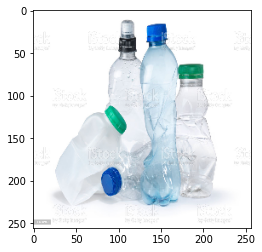

In [21]:
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = keras.preprocessing.image.load_img(path, target_size=(IMG_SIZE,IMG_SIZE))
  imgplot = plt.imshow(img)

  x = keras.preprocessing.image.img_to_array(img)
  x = tf.expand_dims(x, 0) #create a batch
 
  predictions = model.predict(x, batch_size=batch_size)
  score = tf.nn.softmax(predictions[0])

  print(
      "Gambar ini diprediksi sebagai sampah jenis {} dengan {:.2f} % akurasi.".format(classes[np.argmax(score)], 100*np.max(score))
  )